In [ ]:
import serial                            # imports the 'pyserial' library. This library allows Python to communicate with the Serial Ports
import csv                               # imports the library for handling CSV files (CSV - Comma Separated Values)
import time                              # imports the library for time-related functions

# Configuration
COM_PORT = 'COM4'               # the COM port where the RX is connected
BAUD_RATE = 921600              # baud rate for serial communication (matches the RX configuration)
OUTPUT_FILE = "csi_dataset.csv" # the name of the file where unfiltered data will be saved

# the label for the current data session
# 0 = the room is empty
# 1 = the room is not empty
label = 1 

def record_csi_data():
    ser = None # initialize the serial connection variable as 'None' (empty)
    try:       # the 'try' block let's us test a block of code for errors
        # Initialize Serial Connection (opens the specific serial port at the specified speed, 'timeout = 1' means it will wait a second for data before moving on)
        ser = serial.Serial(COM_PORT, BAUD_RATE, timeout = 1) 

        # verify if we want to record data for when the room is empty
        if label == 0:
            time.sleep(45)              # sleep for 45 seconds, enough time for me to leave the room ):
            ser.reset_input_buffer()    # we delete data saved in the buffer during this 45 seconds

        print(f"Connected to {COM_PORT}")                                       # confirms connection
        print(f"Recording Label: {label}")                                      # confirms data for which label is being recorded
        print(f"Saving data to: {OUTPUT_FILE}")                                 # confirms the output file
        print(f"Stop the recording with the 'Interrupt' button in Jupyter.\n")  # instructions on how to stop the recording of data

        # 'with open' opens the file and closes it automatically
        # mode = 'a' (append) -> adds new data to the end of the file without deleting old data
        # newline = '' -> prevents blank lines between data rows
        with open(OUTPUT_FILE, mode = 'a', newline = '') as file:                
            writer = csv.writer(file)   # create a 'writer' object that knows how to write formatted CSV rows

            packets = 0                 # counter for the number of captured packets
            start_time = time.time()    # memorize the time recording started

            while True:  
                try:                            # another 'try' block to handle errors 
                    raw_line = ser.readline()   # reads bytes from the ESP32 until '\n' character is found
                    
                    # verify if we want to record data for when the room is empty
                    if label == 0:
                        current_time = time.time() - start_time # get the current time

                        if current_time > 600:  # record data for 600 seconds (change as needed)
                            break

                    # decode the bytes that we read earlier into a string
                    # 'utf-8' -> the standard text format
                    # errors = 'ignore' -> ignores any weird characters that may appear
                    # .strip() -> removes whitespaces and invisible characters
                    line = raw_line.decode('utf-8', errors = 'ignore').strip()  
                    
                    # we check if the line starts with the key text we set '[CSI DATA]', this will be the 1st element
                    if line.startswith("[CSI DATA]"):
                        parts = line.split(',')     # split the line into a list of elements, using a comma as a separator

                        # extract the metadata (packet information)
                        packet_id = parts[1]        # the 2nd element is the packet ID
                        rssi = parts[2]             # the 3nd element is the Signal Strength
                        data_len = parts[3]         # the 4nd element is the length of the CSI string
                        csi_payload = parts [4:]    # everything from the 5th element onwards is raw CSI data

                        if len(csi_payload) > 10:                                   # check if we have real CSI data and not garbage
                            row = [label, packet_id, rssi, data_len] + csi_payload  # constructing the row for the CSV
                            writer.writerow(row)                                    # write the row in the CSV file

                            packets += 1                                            # increment the number of packets received

                            if packets % 50 == 0:                                   # feedback once every 50 received packets
                                duration = time.time() - start_time                 # how much time passed to gather these 50 packets
                                fps = packets / duration                            # calculate the speed which the packets are being recorded at
                                print(f"Captured: {packets} packets, RSSI : {rssi}dBm, Speed: {fps:.1f}Hz", end = '\r') # prints the status to the screen
                # the 'except' block is used for error handling inside the loop
                except IndexError:
                    continue                # if the line is incomplete (missing parts), skip it and go to the next one        
                except UnicodeDecodeError:
                    continue                # if text decoding fails, skip it
    # the 'except' block is used for error handling outside the loop         
    except serial.SerialException as e:
        print(f"Error: {e}")                        # if the port is busy or the cable is unplugged
    except KeyboardInterrupt:
        print(f"Recording interrupted by User.")    # if we press 'Interrupt' in Jupyter

    # the 'finally' block will be executed regardless if the try block raises an error or not
    finally:
        if ser is not None and ser.is_open: # check if the serial connection was opened
            ser.close()                     # if it was opened, we will close the USB port

# we call the function          
record_csi_data()                    

Connected to COM4
Recording Label: 1
Saving data to: csi_dataset.csv
Stop the recording with the 'Interrupt' button in Jupyter.

Recording interrupted by User.  Length 384dBm, Speed: 30.0Hz


In [ ]:
import re   # imports the 're' (Regular Expression) library. We use it to find patterns (numbers in our case) inside text 

input_file = "csi_dataset.csv"              # the name of the file where unfiltered data is saved 
output_file = "filtered_csi_dataset.csv"    # the name of the file where filtered data will be saved

# Note: the numbers shouldn't differ by much or the model will be inaccurate
packets_label_0 = 0 # count to see how many packets labeled as 0 we have in the filtered dataset
packets_label_1 = 0 # count to see how many packets labeled as 1 we have in the filtered dataset

print(f"Filtering the dataset...")

# opens the input file for reading ('r') and the output file for writing ('w') simultaneously
# 'with' will automatically close the file when the job is done or if an error occurs
with open(input_file, 'r') as fin, open(output_file, 'w') as fout:
    # starts a loop that goes through the input file one line at the time
    for line in fin:
        # re.findall(r'-?\d+',line) scans the entire line of text
        # r'-?\d+' -> searches for any group of digits (\d+)
        numbers_found = re.findall(r'-?\d+',line)

        # we check if the length of the CSI string is 384, if it is, we keep it    
        if numbers_found[2] == '384':

            # check how many label 0 and how many label 1 rows are in our filtered dataset
            if numbers_found[0] == '0':
                packets_label_0 += 1
            else:
                packets_label_1 += 1

            # filtering the raw dataset
            filtered_data = numbers_found[:386]
            filtered_line = ",".join(filtered_data) + "\n"
            fout.write(filtered_line)

print(f"No. of label 0 packets: {packets_label_0}")
print(f"No. of label 1 packets: {packets_label_1}")
print(f"Filtering was succesful.") 

Filtering the dataset...
No. of label 0 packets: 23921
No. of label 1 packets: 26219
Filtering was succesful.


Loading dataset...


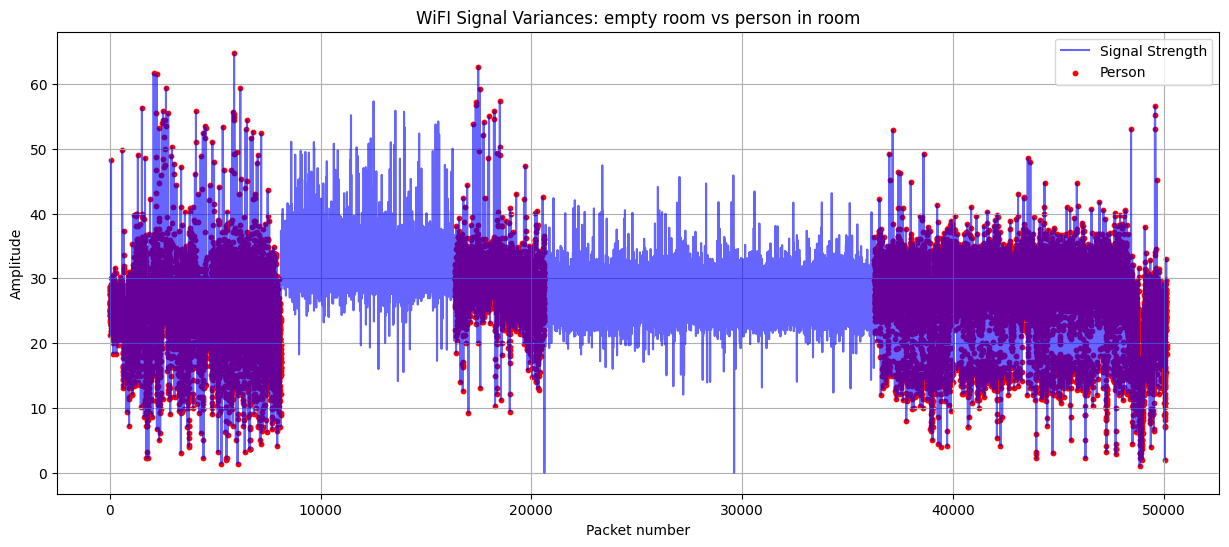

In [10]:
import pandas as pd                 # imports the 'pandas' library which is used for handling data tables (CSV in our case)
import numpy as np                  # imports the 'numpy' library which is used for fast mathematical operations
import matplotlib.pyplot as plt     # imports the plotting library to draw graphs

input_file = "filtered_csi_dataset.csv" # sets the name of the CSV file we want to analyze

def visualize_data():
    print(f"Loading dataset...")

    # the 'try' block lets us test a block of code for errors
    try:
        # reads the CSV file into a DataFrame (a table structure)
        # header = None -> tells pandas there are no column names in the first row
        # on_bad_lines = 'skip' -> ignores corrupted rows instead of crashing the program
        # engine = 'python' -> uses the Python parsing engine
        df = pd.read_csv(input_file, header = None, on_bad_lines = 'skip', engine = 'python')

    except FileNotFoundError:   # catches the error if the input files does not exist
        print(f"Error: file {input_file} not found.")
        return  # stops the function

    # slices the table to get only the raw CSI data
    # iloc[:,4:] -> selects all rows (:), and columns starting from index 4 to the end (4:)
    # columns 0, 1, 2, 3 are metadata which will be ignored
    # .values -> converts the pandas table into raw numpy array (matrix) for math operations
    raw_data = df.iloc[:,4:].values

    # the raw data is interleaved (real, imaginary, real, imaginary...)
    # we extract the real parts by taking every 2nd column starting from index 0
    # we extract the imaginary parts by taking every 2nd column starting from index 1
    real_parts = raw_data[:, 0::2]
    imaginary_parts = raw_data[:, 1::2]

    # we calculate the amplitude (signal strength) using Pythagorean theorem
    # sqrt(real^2 + imaginary^2)
    amplitude = np.sqrt(real_parts**2 + imaginary_parts**2)

    # we choose one specific frequency to visualize the data
    frequency = 90

    # creates a new plotting window with a specified size (15-width, 6-height)
    plt.figure(figsize = (15,6))

    # finds the row indicies where a person was present in the room
    # df[0] refers to column 0 (the label), and we look for rows with label == 1
    person_indicies = df[df[0] == 1].index

    # draws the main blue line showing signal strength over time for the chosen frequency
    # alpha = 0.6 makes the line slightly transparent
    plt.plot(amplitude[:, frequency], label = "Signal Strength", color = 'blue', alpha = 0.6)
    
    # overlay red dots on top of the blue line only where a person was present
    # we use the 'person_indicies' to select X (time) and Y (amplitude) coordinates
    # color = red sets the color of the dots and s = 10 sets the size of the dots 
    plt.scatter(person_indicies, amplitude[person_indicies, frequency], color = 'red', s = 10, label = 'Person')
    plt.title("WiFI Signal Variances: empty room vs person in room")    # sets the title of the graph
    plt.xlabel("Packet number")                                         # labels the X-axis (time)
    plt.ylabel("Amplitude")                                             # labels the Y-axis (signal power)
    plt.legend()                                                        # adds the legend box
    plt.grid(True)                                                      # adds a grid background to make it easier to read values
    plt.show()                                                          # renders and displays the final graph

# calls the function to execute the code above
visualize_data()    


Loading and processing the dataset...
Applying Savitzky-Golay filter to smooth the signal...


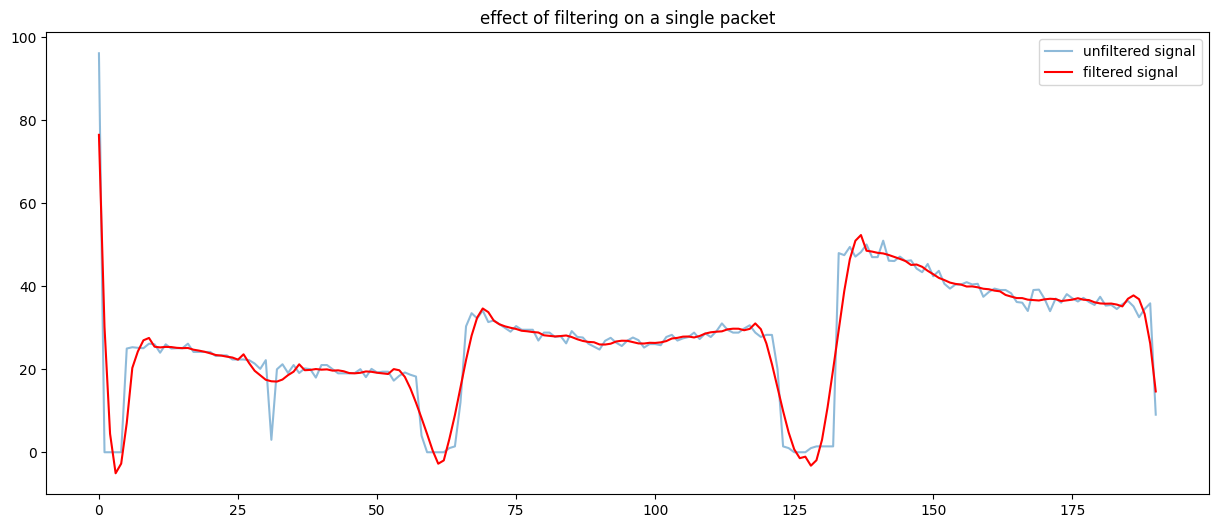

Applying PCA (Principal Component Analysis) to reduce dimensionality...
Original feature count: 191
Filtered feature count: 4
Training the model...
Training accuracy: 99.91%
Testing accuracy: 96.34%


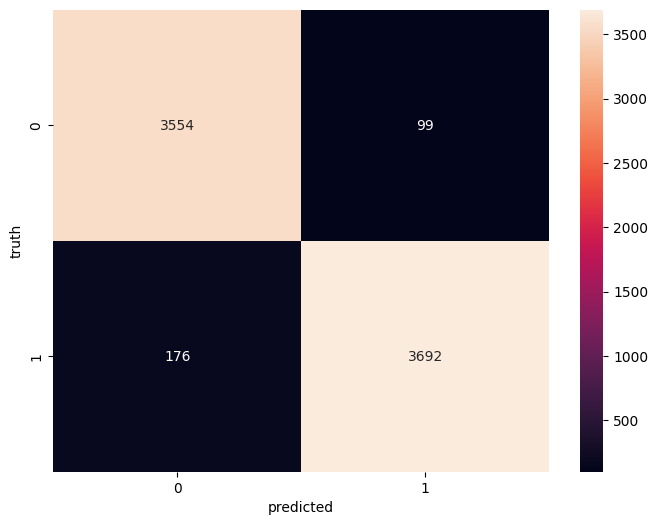

In [ ]:
import pandas as pd                                             # library for handling data in tables (DataFrames)
import numpy as np                                              # library for fast mathematical operations (matrices, arrays)
import matplotlib.pyplot as plt                                 # library for plotting graphs    
import seaborn as sn                                            # library for making prettier graphs (heatmap in our case)

# imports specific tool from 'sklearn' (Scikit-Learn) Machine Learning library
from sklearn.model_selection import train_test_split            # tool to split data into 'training' and 'testing' sets
from sklearn.impute import SimpleImputer                        # tool to help replace the missing data with plausible values
from sklearn.ensemble import RandomForestClassifier             # the ML model we are using (a collection of silly decision trees)
from sklearn.metrics import accuracy_score, confusion_matrix    # tools to grade the models performance
from sklearn.decomposition import PCA                           # tool to help reduce the dimension of the dataset
from scipy.signal import savgol_filter                          # tool to filter noise and smooth the data

input_file = "filtered_csi_dataset.csv" # sets the name of the CSV file we will use to train our model

print(f"Loading and processing the dataset...")

try:
    # reads the CSV file into a DataFrame (a table structure)
    # header = None -> tells pandas there are no column names in the first row
    # on_bad_lines = 'skip' -> ignores corrupted rows instead of crashing the program
    # engine = 'python' -> uses the Python parsing engine
    df = pd.read_csv(input_file, header = None, on_bad_lines = 'skip', engine = 'python')

    # standard error handling
except FileNotFoundError:
    print(f"Error: file {input_file} not found.")
    raise   # stops the program if the file is missing

# y_raw contains the 'answers' (0 for empty, 1 for person in room)
y_raw = df.iloc[:,0].values

# X_raw contains the 'questions' (the raw CSI data)
X_raw = df.iloc[:,4:].values

# the raw data is interleaved (real, imaginary, real, imaginary...)
# we extract the real parts by taking every 2nd column starting from index 0
# we extract the imaginary parts by taking every 2nd column starting from index 1
real_parts = X_raw[:, 0::2]
imaginary_parts = X_raw[:, 1::2]

# we calculate the amplitude (signal strength) using Pythagorean theorem
# sqrt(real^2 + imaginary^2)
X_amp = np.sqrt(real_parts**2 + imaginary_parts**2)

print(f"Applying Savitzky-Golay filter to smooth the signal...")

# apply filter to every packet (row)
# window_length = 11 -> looks at 11 data points at a time
# polyorder = 3 -> fits a 3rd degree polynomial
X_filtered  = savgol_filter(X_amp, window_length = 11, polyorder = 3, axis = 1)

# a graph to visualize the difference between the filtered and unfiltered signal
plt.figure(figsize = (15,6))
plt.plot(X_amp[0], label = 'unfiltered signal', alpha = 0.5)
plt.plot(X_filtered[0], label = 'filtered signal', color = 'red')
plt.title("effect of filtering on a single packet")
plt.legend()
plt.show()

# update X_amp
X_amp = X_filtered

print(f"Applying PCA (Principal Component Analysis) to reduce dimensionality...")

# replaces NaNs with the mean of the column
imputer = SimpleImputer(strategy = 'mean')

# apply imputation to our data (this will fill the missing data spots so PCA works)
X_amp = imputer.fit_transform(X_amp)
                                   
# n_components = 0.95 -> the numbers of components to keep
pca = PCA(n_components = 0.95)

# fit and transform the data
X_pca = pca.fit_transform(X_amp)

print(f"Original feature count: {X_amp.shape[1]}")
print(f"Filtered feature count: {X_pca.shape[1]}")

# update X_amp
X_amp = X_pca

print(f"Training the model...")

# here we will split the data into two parts:
# X_train, y_train (85%) is used to train the model
# X_test, y_test (15%) is used to test the model
X_train, X_test, y_train, y_test = train_test_split(X_amp, y_raw, test_size = 0.15)

# we create a 'RandomForest' which consists of 30 decision trees (n_estimators = 30)
model = RandomForestClassifier(n_estimators = 30)

# the model looks at X_train (CSI patterns) and learns to associate them with y_train (labels)
model.fit(X_train, y_train)

# we ask the model to predict the labels for the test data (X_test)
# the model will not see the real answers (y_test) just yet
y_pred = model.predict(X_test)

# we compare the model's guesses (y_train) with the real answers (X_train)
train_accuracy = model.score(X_train, y_train)

# we compare the model's guesses (y_pred) with the real answers (y_test)
accuracy = accuracy_score(y_test, y_pred)

# print both, training and testing accuracies to check if the model is overfitting
print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing accuracy: {accuracy * 100:.2f}%")

# creates a table showing where the model was right and where it was confused
cm = confusion_matrix(y_test,y_pred)

# %matplotlib inline is a command for Jupyter Notebooks to show graphs directly below the cell
%matplotlib inline
plt.figure(figsize=(8,6))       # sets the size of the graph

# draws a colored heatmap of the confusion matrix
# annot = True writes the actual numbers inside the colored boxes
# fmt = 'd' formats the numbers as decimal integers
sn.heatmap(cm, annot = True, fmt = 'd')   
plt.xlabel("predicted")          # the label the model guessed
plt.ylabel("truth");             # the actual label
